In [1]:
import pandas as pd
from constants import FEATURE_COLS


df = pd.read_csv("gene_array_data.csv")
df_data = df[FEATURE_COLS].values
gene_df = df[df["type"] == "gene"]
gene_data = gene_df[FEATURE_COLS].values

df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X127,X128,X129,X130,type,row,col,well,set,type.f
0,0.028406,0.366509,-0.409095,-0.860267,-1.199625,-0.957421,1.069801,1.955345,0.337789,0.077923,...,0.232675,-0.373978,0.761471,-0.038931,fit1,1,1,1,1,2
1,-1.676787,-1.052529,-0.199561,2.466620,3.211458,1.047448,0.250414,-2.472738,0.507739,1.739547,...,-1.219446,3.589147,0.578128,2.398961,bscl2,1,2,2,1,1
2,0.299722,0.172662,-0.347225,-0.716339,-0.626394,-0.929586,1.347048,-0.421019,-0.189115,-0.143108,...,-1.175065,-0.603218,-2.012574,0.793229,gene,1,3,3,1,3
3,0.337794,0.311708,0.163537,-0.152534,-0.681377,-0.345225,-0.124524,-0.448789,-0.457341,-0.415081,...,0.006033,-0.876915,-0.999876,0.457990,gene,1,4,4,1,3
4,0.299525,0.346085,-0.899016,-0.731644,-1.182621,-0.044624,0.513639,0.128500,0.000759,0.343600,...,-0.271680,-1.492425,-1.609442,0.096242,gene,1,5,5,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,-0.086834,-0.389390,-0.664103,0.121154,0.884493,0.620821,0.450445,0.870069,0.097326,-0.215136,...,0.248297,1.034151,0.109801,-1.521708,gene,16,20,380,11,3
4220,0.196860,0.733349,-0.305704,-1.420634,-0.254738,-0.599128,-0.888902,0.526654,-0.211608,-0.764044,...,-0.434300,-0.275161,0.425499,-1.322050,gene,16,21,381,11,3
4221,0.075461,-0.213490,0.845081,-0.568241,-0.727948,0.093058,-0.455171,0.598393,0.162431,-1.002004,...,-0.379338,-0.904349,0.408527,-1.017328,gene,16,22,382,11,3
4222,-0.232965,-0.243492,1.629059,-0.444117,0.319438,0.415589,-0.181854,0.959834,-0.991392,-0.199994,...,0.441055,0.329625,1.664439,-1.224852,rf,16,23,383,11,4


In [2]:
from scipy.spatial import distance
import numpy as np


# Calculate the mean vector and covariance matrix of the reference data
gene_mean = np.mean(gene_data, axis=0)
gene_cov = np.cov(gene_data, rowvar=False)


# Calculate Mahalanobis distance for each row in the dataframe
df["mahalanobis_distance"] = df.apply(
    lambda row: distance.mahalanobis(
        row[FEATURE_COLS], gene_mean, np.linalg.inv(gene_cov)
    ),
    axis=1,
)

# Calculate the 95th percentile threshold using only the gene data
threshold = np.percentile(
    df[df["type"] == "gene"]["mahalanobis_distance"], 100 - (100 / 3520) * 100
)

# Create a new column indicating whether each sample exceeds the threshold
df["mahalanobis_outlier"] = df["mahalanobis_distance"] > threshold

outlier_summary = df.groupby("type")["mahalanobis_outlier"].agg(["count", "sum"])
outlier_summary["percentage"] = (
    outlier_summary["sum"] / outlier_summary["count"]
) * 100
print(outlier_summary)

         count  sum  percentage
type                           
bscl2      176  166   94.318182
fit1        88    6    6.818182
gene      3520  100    2.840909
rf         264   20    7.575758
rfnotDL    176  172   97.727273


In [3]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=0, contamination=100 / 3520).fit(gene_data)
outlier_scores = clf.predict(df[FEATURE_COLS].values)

# outlier_scores = IsolationForest(
#     random_state=0, contamination=((176) * 2 + 100) / 3520
# ).fit_predict(df[FEATURE_COLS].values)

df["isolation_forest_outlier"] = outlier_scores == -1

outlier_summary = df.groupby("type")["isolation_forest_outlier"].agg(["count", "sum"])
outlier_summary["percentage"] = (
    outlier_summary["sum"] / outlier_summary["count"]
) * 100
print(outlier_summary)


         count  sum  percentage
type                           
bscl2      176  171   97.159091
fit1        88   10   11.363636
gene      3520  100    2.840909
rf         264   13    4.924242
rfnotDL    176  166   94.318182


In [4]:
import sklearn.neighbors


# Detect outliers using LocalOutlierFactor
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.15).fit_predict(
    df[FEATURE_COLS].values
)

df["lof_outlier"] = outlier_scores == -1

# Count how many samples of each type exceed the threshold
outlier_summary = df.groupby("type")["lof_outlier"].agg(["count", "sum"])
outlier_summary["percentage"] = (
    outlier_summary["sum"] / outlier_summary["count"]
) * 100
print(outlier_summary)


         count  sum  percentage
type                           
bscl2      176   21   11.931818
fit1        88   43   48.863636
gene      3520  497   14.119318
rf         264   52   19.696970
rfnotDL    176   21   11.931818


In [5]:
import pandas as pd


def create_dimension_reduction_df(
    transformed_data,
    n_components,
    prefix,
    df,
):
    transformed_data = transformed_data[:, :n_components]
    columns = [f"{prefix}{i + 1}" for i in range(n_components)]
    result_df = pd.DataFrame(transformed_data, columns=columns)

    # Add metadata columns from original DataFrame
    for col in df.columns:
        if col not in FEATURE_COLS:
            result_df[col] = df[col].values

    return result_df

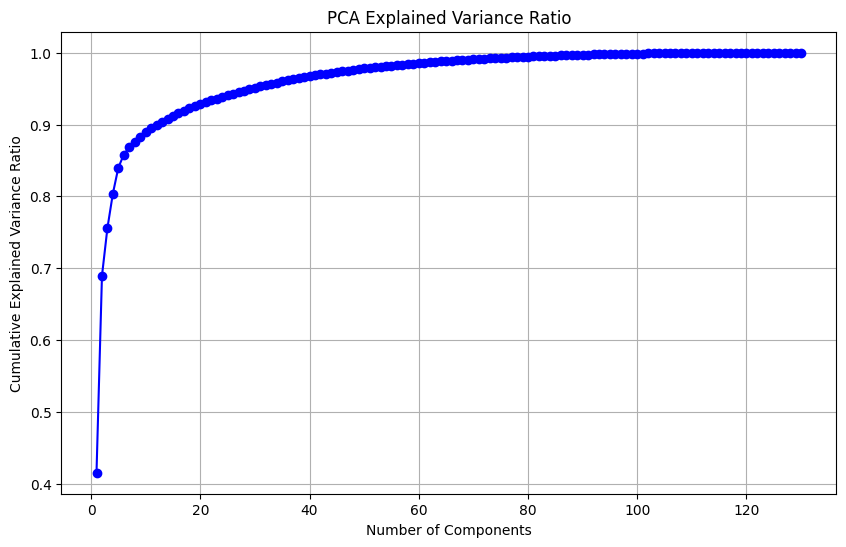

In [8]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
from plotting_utils import plot_3d_scatter


def perform_pca(X_scaled, plot_explained_variance=True):
    """Perform PCA and return transformed data and PCA object."""
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    if plot_explained_variance:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        plt.figure(figsize=(10, 6))
        plt.plot(
            range(1, len(explained_variance_ratio) + 1),
            cumulative_variance_ratio,
            "bo-",
        )
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance Ratio")
        plt.title("PCA Explained Variance Ratio")
        plt.grid(True)
        plt.show()
    return X_pca


HOVER_COLS = [
    "row",
    "col",
    "set",
]

X_pca = perform_pca(df_data, plot_explained_variance=True)


pca_df = create_dimension_reduction_df(
    X_pca,
    3,
    "PC",
    df,
)

pca_fig = plot_3d_scatter(
    pca_df,
    "PC1",
    "PC2",
    "PC3",
    title="3D PCA Projection",
    hover_data=HOVER_COLS,
    type_col="type",
    outlier_col="isolation_forest_outlier",
)


In [7]:
# Apply UMAP for dimensionality reduction

from umap import UMAP


def perform_umap(data, n_components=3, random_state=42, n_neighbors=200, min_dist=0.8):
    """Perform UMAP dimensionality reduction on the input data."""
    umap_model = UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    umap_result = umap_model.fit_transform(data)
    return umap_result


# Perform UMAP and create DataFrame
X_umap = perform_umap(df_data)
umap_df = create_dimension_reduction_df(X_umap, 3, "UMAP", df)

# Plot UMAP results
umap_fig = plot_3d_scatter(
    umap_df,
    "UMAP1",
    "UMAP2",
    "UMAP3",
    title="3D UMAP Projection",
    type_col="type",
    hover_data=HOVER_COLS,
    outlier_col="isolation_forest_outlier",
)


/Users/jyin/Documents/Yale Spring 2025/S&DS 425/GeneArray/env/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/jyin/Documents/Yale Spring 2025/S&DS 425/GeneArray/env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

